# [NTDS'19] tutorial 3: build a graph from features
[ntds'19]: https://github.com/mdeff/ntds_2019

[Benjamin Ricaud](https://people.epfl.ch/benjamin.ricaud), [EPFL LTS2](https://lts2.epfl.ch).

* Dataset: [Iris](https://archive.ics.uci.edu/ml/datasets/Iris)
* Tools: [pandas](https://pandas.pydata.org), [numpy](http://www.numpy.org), [scipy](https://www.scipy.org), [matplotlib](https://matplotlib.org), [networkx](https://networkx.github.io), [gephi](https://gephi.org/)

## Tools

By convention, the first lines of code are always about importing the packages we'll use.

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from matplotlib import pyplot as plt
import networkx as nx

Tutorials on pandas can be found at:
* <https://pandas.pydata.org/pandas-docs/stable/10min.html>
* <https://pandas.pydata.org/pandas-docs/stable/tutorials.html>

Tutorials on numpy can be found at:
* <https://docs.scipy.org/doc/numpy/user/quickstart.html>
* <http://www.scipy-lectures.org/intro/numpy/index.html>
* <http://www.scipy-lectures.org/advanced/advanced_numpy/index.html>

A tutorial on networkx can be found at:
* <https://networkx.github.io/documentation/stable/tutorial.html>

The following line is a [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html). It enables plotting inside the notebook.

In [2]:
%matplotlib inline
# %matplotlib notebook

## Import and explore the data

We will play with the famous Iris dataset. This dataset can be found in many places on the net and was first released at <https://archive.ics.uci.edu/ml/index.php>. For example it is stored on [Kaggle](https://www.kaggle.com/uciml/iris/), with many demos and Jupyter notebooks you can test (have a look at the "kernels" tab).

![Iris Par Za — Travail personnel, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=144395](https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/Iris_germanica_002.jpg/251px-Iris_germanica_002.jpg)

In [3]:
iris = pd.read_csv('data/iris.csv')
iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


The description of the entries is given here:
https://www.kaggle.com/uciml/iris/home

In [4]:
iris['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [5]:
iris.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


## Build a graph from the features

We are going to build a graph from these data. The idea is to represent iris samples (rows of the table) as nodes, with connections depending on their physical similarity.

The main question is how to define the notion of similarity between the flowers. For that, we need to introduce a measure of similarity. It should use the properties of the flowers and provide a positive real value for each pair of samples. 

*Remark:* The value should increase with the similarity.

Let us separate the data into two parts: physical properties and labels.

In [6]:
features = iris.loc[:, ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
species = iris.loc[:, 'Species']

In [7]:
features.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [8]:
species.head()

0    Iris-setosa
1    Iris-setosa
2    Iris-setosa
3    Iris-setosa
4    Iris-setosa
Name: Species, dtype: object

### Similarity, distance and edge weight

You can define many similarity measures. One of the most intuitive and perhaps the easiest to program relies on the notion of distance. If a distance between samples is defined, we can compute the weight accordingly: if the distance is short, which means the nodes are similar, we want a strong connection between them (large weight).

#### Different distances
The cosine distance is a good candidate for high-dimensional data. It is defined as follows:
$$d(u,v) = 1 - \frac{u \cdot v} {\|u\|_2 \|v\|_2},$$
where $u$ and $v$ are two feature vectors.
 
The distance is proportional to the angle formed by the two vectors (0 if colinear, 1 if orthogonal, 2 if opposed direction).

Alternatives are the [$p$-norms](https://en.wikipedia.org/wiki/Norm_%28mathematics%29#p-norm) (or $\ell_p$-norms), defined as
$$d(u,v) = \|u - v\|_p,$$
of which the Euclidean distance is a special case with $p=2$.

The `pdist` function from `scipy` computes the pairwise distance. By default it is the Euclidian distance. `features.values` is a numpy array extracted from the Pandas dataframe. Very handy.

In [9]:
#from scipy.spatial.distance import pdist, squareform
pdist?

Signature: pdist(X, metric='euclidean', *args, **kwargs)
Docstring:
Pairwise distances between observations in n-dimensional space.

See Notes for common calling conventions.

Parameters
----------
X : ndarray
    An m by n array of m original observations in an
    n-dimensional space.
metric : str or function, optional
    The distance metric to use. The distance function can
    be 'braycurtis', 'canberra', 'chebyshev', 'cityblock',
    'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
    'jaccard', 'jensenshannon', 'kulsinski', 'mahalanobis', 'matching',
    'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
    'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule'.
*args : tuple. Deprecated.
    Additional arguments should be passed as keyword arguments
**kwargs : dict, optional
    Extra arguments to `metric`: refer to each metric documentation for a
    list of all possible arguments.

    Some possible arguments:

    p : scalar
    The p-norm to apply for Minko

In [10]:
distances = pdist(features.values, metric='euclidean')
# other metrics: 'cosine', 'cityblock', 'minkowski'

Now that we have a distance, we can compute the weights.

#### Distance to weights
A common function used to turn distances into edge weights is the Gaussian function:
$$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{\sigma^2} \right),$$
where $\sigma$ is the parameter which controls the width of the Gaussian.
  
The function giving the weights should be positive and monotonically decreasing with respect to the distance. It should take its maximum value when the distance is zero, and tend to zero when the distance increases. Note that distances are non-negative by definition. So any funtion $f : \mathbb{R}^+ \rightarrow [0,C]$ that verifies $f(0)=C$ and $\lim_{x \rightarrow +\infty}f(x)=0$ and is *strictly* decreasing should be adapted. The choice of the function depends on the data.

Some examples:
* A simple linear function $\mathbf{W}(u,v) = \frac{d_{max} - d(u, v)}{d_{max} - d_{min}}$. As the cosine distance is bounded by $[0,2]$, a suitable linear function for it would be $\mathbf{W}(u,v) = 1 - d(u,v)/2$.
* A triangular kernel: a straight line between the points $(0,1)$ and $(t_0,0)$, and equal to 0 after this point.
* The logistic kernel $\left(e^{d(u,v)} + 2 + e^{-d(u,v)} \right)^{-1}$.
* An inverse function $(\epsilon+d(u,v))^{-n}$, with $n \in \mathbb{N}^{+*}$ and $\epsilon \in \mathbb{R}^+$.
* You can find some more [here](https://en.wikipedia.org/wiki/Kernel_%28statistics%29).
 

In [11]:
# Let us use the Gaussian function
kernel_width = distances.mean()
weights_list = np.exp(-distances**2 / kernel_width**2)

In [12]:
# Turn the list of weights into a matrix.
weight_matrix = squareform(weights_list)

**Exercise:** Find the nodes with highest degree and display their respective entry in the `iris` dataframe. Do they belong to the same iris species?

In [13]:
sum_weight = np.sum(weight_matrix, axis=1)
max_weight = np.max(sum_weight)
max_idx = np.argwhere(sum_weight == max_weight)
print('Highest degree index', max_idx[0]) # only one?
iris.iloc[max_idx[0]]

Highest degree index [78]


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
78,79,6.0,2.9,4.5,1.5,Iris-versicolor


Sometimes, you may need to compute additional features before processing them with some machine learning or some other data processing step. With Pandas, it is as simple as that:

In [14]:
# Compute a new column using the existing ones.
features['SepalLengthSquared'] = features['SepalLengthCm']**2
features.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,SepalLengthSquared
0,5.1,3.5,1.4,0.2,26.01
1,4.9,3.0,1.4,0.2,24.01
2,4.7,3.2,1.3,0.2,22.09
3,4.6,3.1,1.5,0.2,21.16
4,5.0,3.6,1.4,0.2,25.00


Coming back to the weight matrix, we have obtained a full matrix but we may not need all the connections (reducing the number of connections saves some space and computations!). We can sparsify the graph by removing the values (edges) below some fixed threshold. Let us see what kind of threshold we could use:

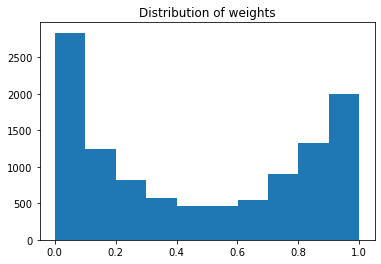

In [15]:
plt.hist(weights_list)
plt.title('Distribution of weights')
plt.show()

In [16]:
# Let us choose a threshold of 0.6.
# Too high, we will have disconnected components
# Too low, the graph will have too many connections
weight_matrix[weight_matrix < 0.6] = 0
np.count_nonzero(weight_matrix)

9548

**Exercise:** Plot the number of edges with respect to the threshold, for threshold values between 0 and 1.

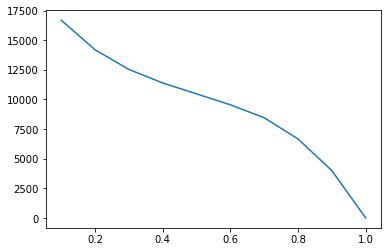

In [17]:
new_weight_matrix = squareform(weights_list)
num_edges = np.zeros(10)
for i in range(1, 11):
    weight_matrix_tmp = new_weight_matrix.copy()
    weight_matrix_tmp[weight_matrix_tmp < i / 10.0] = 0
    num_edges[i - 1] = np.count_nonzero(weight_matrix_tmp)

plt.plot(np.arange(0.1, 1.1, 0.1), num_edges)

## *Remark:* The distances presented here do not work well for categorical data.

## Graph visualization

To conclude, let us visualize the graph. We will use the python module networkx.

In [18]:
# A simple command to create the graph from the adjacency matrix.
graph = nx.from_numpy_array(weight_matrix)

Let us try some direct visualizations using networkx.

In [19]:
# Let us add some colors
colors = species.values
colors[colors == 'Iris-setosa'] = 0
colors[colors == 'Iris-versicolor'] = 1
colors[colors == 'Iris-virginica'] = 2

/Users/dino/.pyenv/versions/miniconda3-latest/envs/ntds_2019/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


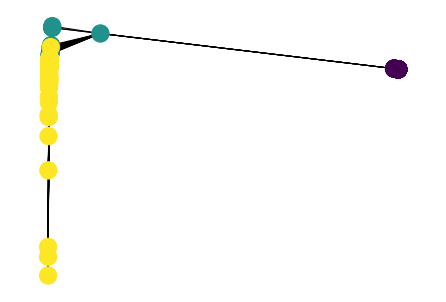

In [20]:
nx.draw_spectral(graph, node_color=colors)

Oh! It seems to be separated in 3 parts! Are they related to the 3 different species of iris?

Let us try another [layout algorithm](https://en.wikipedia.org/wiki/Graph_drawing#Layout_methods), where the edges are modeled as springs.

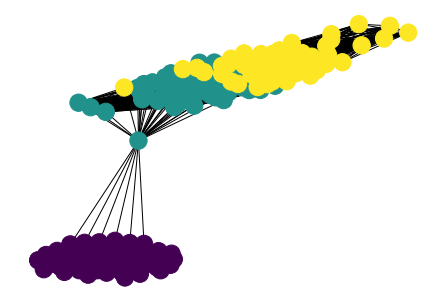

In [21]:
nx.draw_spring(graph, node_color=colors)

Save the graph to disk in the `gexf` format, readable by gephi and other tools that manipulate graphs. You may now explore the graph using gephi and compare the visualizations.

In [22]:
nx.write_gexf(graph, 'iris.gexf')

**Exercise 1:**
Modify the experiment such that the distance is computed using normalized features, i.e., all features (columns of `features`) having the same mean and variance.
This avoids having some features with too much importance in the computation of distance.


In [23]:
features = iris.loc[:, ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
normalized_features = (features - features.mean()) / features.std()
normalized_features.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,-0.897674,1.028611,-1.336794,-1.308593
1,-1.139200,-0.124540,-1.336794,-1.308593
2,-1.380727,0.336720,-1.393470,-1.308593
3,-1.501490,0.106090,-1.280118,-1.308593
4,-1.018437,1.259242,-1.336794,-1.308593


In [24]:
distances = pdist(features.values, metric='euclidean')

In [25]:
# Let us use the Gaussian function
kernel_width = distances.mean()
weights_list = np.exp(-distances**2 / kernel_width**2)

In [26]:
# Turn the list of weights into a matrix.
weight_matrix = squareform(weights_list)

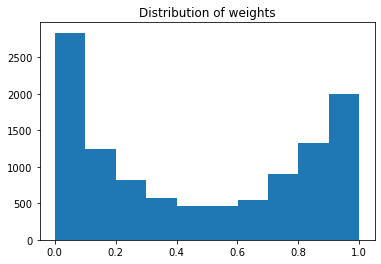

In [27]:
plt.hist(weights_list)
plt.title('Distribution of weights')
plt.show()

In [28]:
weight_matrix[weight_matrix < 0.6] = 0

In [29]:
graph = nx.from_numpy_array(weight_matrix)
colors = species.values
colors[colors == 'Iris-setosa'] = 0
colors[colors == 'Iris-versicolor'] = 1
colors[colors == 'Iris-virginica'] = 2

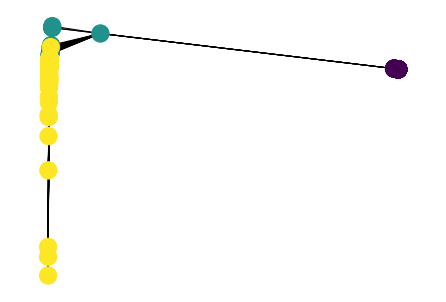

In [30]:
nx.draw_spectral(graph, node_color=colors)

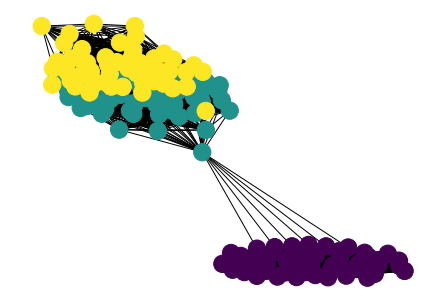

In [31]:
nx.draw_spring(graph, node_color=colors)

**Exercise 2 (advanced):**
Construct the graph of k-nearest neighbors (choose $k=4$).
You may read the [kNN section of scikit-learn](https://scikit-learn.org/stable/modules/neighbors.html) and use this python module.

In [32]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(weight_matrix)
distances, indices = nbrs.kneighbors(weight_matrix)

In [33]:
distances

array([[0.        , 1.40078004, 1.4027453 , 1.40725966],
       [0.        , 1.34350246, 1.37222447, 1.39203631],
       [0.        , 1.3984266 , 1.39868089, 1.39868089],
       [0.        , 1.36377844, 1.39758736, 1.39974355],
       [0.        , 1.38182377, 1.38377364, 1.40067945],
       [0.        , 1.37702298, 1.38565733, 1.41043223],
       [0.        , 1.37222447, 1.3733314 , 1.37487539],
       [0.        , 1.40381391, 1.40482419, 1.40756969],
       [0.        , 1.40317251, 1.41240052, 1.53881857],
       [0.        , 1.34849175, 1.37487539, 1.39581056],
       [0.        , 1.36848052, 1.39169156, 1.3997278 ],
       [0.        , 1.37281767, 1.38503832, 1.39261325],
       [0.        , 1.35035979, 1.38064253, 1.39255247],
       [0.        , 1.40317251, 1.42276583, 1.56666085],
       [0.        , 1.39200457, 1.3963108 , 1.41756826],
       [0.        , 1.75906127, 1.84796244, 1.87926152],
       [0.        , 1.37513712, 1.38565733, 1.38666568],
       [0.        , 1.39763165,

In [34]:
indices

array([[  0,  20,  31,  44],
       [  1,  22,   6,  42],
       [  2,  29,   9,  37],
       [  3,  22,  35,   1],
       [  4,  20,  31,  28],
       [  5,  32,  16,  18],
       [  6,   1,  35,   9],
       [  7,  35,  40,  22],
       [  8,  13,  38,  42],
       [  9,  22,   6,  35],
       [ 10,  44,  22,  46],
       [ 11,  35,  22,  31],
       [ 12,  22,   6,  42],
       [ 13,   8,  38,  42],
       [ 14,  33,  18,  32],
       [ 15,  14,  33,  18],
       [ 16,  32,   5,  18],
       [ 17,  20,  11,  31],
       [ 18,  32,  33,  16],
       [ 19,  20,  36,  31],
       [ 20,  22,  19,  44],
       [ 21,  20,  36,  31],
       [ 22,  20,  44,  31],
       [ 23,  24,  43,  25],
       [ 24,  43,  25,  23],
       [ 25,  24,  43,  23],
       [ 26,  24,  25,  43],
       [ 27,  22,  21,  40],
       [ 28,  44,  22,  11],
       [ 29,  22,  35,   1],
       [ 30,  24,  43,  25],
       [ 31,  22,  44,  46],
       [ 32,  18,  16,   5],
       [ 33,  18,  14,   5],
       [ 34,  